In [1]:
from PIL import Image
from os import listdir
from os.path import isdir
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

# Pré-processamento

### Carregar Imagem

In [2]:
desired_size = 160

def select_image(filename):
    # load image from file
    image = Image.open(filename)
    # convert to RGB, if needed
    image = image.convert('RGB')
    
    old_size = image.size
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    
    image = image.resize(new_size,Image.ANTIALIAS)
    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(image, ((desired_size-new_size[0])//2,
                    (desired_size-new_size[1])//2))
    
    # convert to array
    return np.asarray(new_im)

### Criar Dataset Personalizado

In [3]:
def load_classes(directory, subdir, imagens, labels):
    

    for filename in listdir(directory):

        path = directory + filename

        try:
            imagens.append(select_image(path))
            labels.append(subdir)
        except:
            print("Erro ao ler imagem {}".format(path))

    return imagens, labels

### Selecionar Dataset

In [4]:
def select_data_set(directory):

    imagens = list()
    labels = list()

    for subdir in listdir(directory):
        # path
        path = directory + subdir + '/'
        
        if not isdir(path):
            continue
        imagens, labels = load_classes(path, subdir, imagens, labels)

    return imagens, labels

In [5]:
dataset = r"/simulated_mask_dataset/db/"
fake_dataset = r"/simulated_mask_dataset/db_masked/"
imagens, labels  = select_data_set(dataset)
imagens_fake, labels_fake  = select_data_set(fake_dataset)

In [6]:
imagens_array = np.array(imagens) / 255.0  ## convertendo de lista para array
imagens_fake_array = np.array(imagens_fake) / 255.0

In [7]:
labels_array = np.array(labels)  ## convertendo de lista para array
labels_fake_array = np.array(labels_fake)

In [8]:
imagens_array.shape

(6032, 160, 160, 3)

In [9]:
labels_array.shape

(6032,)

## Labels

In [10]:
lb = LabelEncoder()
labels_array = lb.fit_transform(labels_array)
labels_array = to_categorical(labels_array)
labels_fake_array = lb.fit_transform(labels_fake_array)
labels_fake_array = to_categorical(labels_fake_array)

In [11]:
labels_array.shape

(6032, 30)

## Hyperparametros

In [12]:
batch_size   = 128
input_shape  = (160, 160, 3)
random_state = 42
alpha        = 1e-5
epoch        = 1000

## CALLBACKS

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [14]:
filepath="fake.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [15]:
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, min_delta=alpha, patience=100, verbose=1)

In [16]:
callbacks = [checkpoint, lr_reduce]

In [17]:
nsamples, nx, ny, nz = imagens_array.shape
imagens_array = imagens_array.reshape((nsamples,nx*ny*nz))
sm = SMOTE(random_state=random_state)
imagens_array, labels_array = sm.fit_resample(imagens_array, labels_array)

/home/italo/anaconda3/envs/gputest/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [18]:
n2samples, n2x, n2y, n2z = imagens_fake_array.shape
imagens_fake_array = imagens_fake_array.reshape((n2samples,n2x*n2y*n2z))
imagens_fake_array, labels_fake_array = sm.fit_resample(imagens_fake_array, labels_fake_array)

/home/italo/anaconda3/envs/gputest/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [19]:
imagens_array = np.concatenate((imagens_array, imagens_fake_array))
labels_array = np.concatenate((labels_array, labels_fake_array))
nsamples, n = imagens_array.shape
imagens_array = imagens_array.reshape(nsamples, nx, ny, nz)
# n2samples, n2 = imagens_fake_array.shape
# imagens_fake_array = imagens_fake_array.reshape(n2samples, n2x, n2y, n2z)
# imagens_array = imagens_array + imagens_fake_array
# labels_array = labels_array + labels_fake_array

In [20]:
imagens_array.shape

(11160, 160, 160, 3)

In [21]:
(trainX, testX, trainY, testY) = train_test_split(imagens_array, labels_array, test_size=0.20, random_state=random_state)
del imagens_array
del imagens
del imagens_fake_array
del imagens_fake
del labels_array
del labels_fake_array

## DATA AUGMENTATION

In [22]:
train_datagen = ImageDataGenerator(
        horizontal_flip= True,
        rotation_range=20,
        zoom_range=0.2,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        fill_mode='nearest'
        )

train_datagen.fit(trainX)

data_aug = train_datagen.flow(trainX, trainY, batch_size=batch_size)

## TRANSFER LEARNING

In [23]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

In [24]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Retreinando parte da VGG16

In [25]:
conv_base.trainable = True
set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

In [26]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

## Criando Modelo

In [27]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu',input_dim=512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(30, activation='softmax'))

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 1024)              525312    
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               5

## Compilar modelo

In [29]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [30]:
history = model.fit(data_aug,
                    epochs=epoch,
                    steps_per_epoch=len(trainX)// batch_size,
                    validation_data=(testX, testY),
                    validation_steps=len(testX) // batch_size,
                    callbacks=callbacks)

Epoch 1/1000
69/69 [==============================] - ETA: 0s - loss: 3.4209 - accuracy: 0.0381
Epoch 00001: val_accuracy improved from -inf to 0.03226, saving model to fake.h5
69/69 [==============================] - 86s 1s/step - loss: 3.4209 - accuracy: 0.0381 - val_loss: 9.8688 - val_accuracy: 0.0323 - lr: 0.0010
Epoch 2/1000
69/69 [==============================] - ETA: 0s - loss: 3.2189 - accuracy: 0.0634
Epoch 00002: val_accuracy improved from 0.03226 to 0.05735, saving model to fake.h5
69/69 [==============================] - 73s 1s/step - loss: 3.2189 - accuracy: 0.0634 - val_loss: 4.2562 - val_accuracy: 0.0573 - lr: 0.0010
Epoch 3/1000
69/69 [==============================] - ETA: 0s - loss: 3.0443 - accuracy: 0.0673
Epoch 00003: val_accuracy improved from 0.05735 to 0.05869, saving model to fake.h5
69/69 [==============================] - 73s 1s/step - loss: 3.0443 - accuracy: 0.0673 - val_loss: 3.6099 - val_accuracy: 0.0587 - lr: 0.0010
Epoch 4/1000
69/69 [=================

Epoch 28/1000
69/69 [==============================] - ETA: 0s - loss: 2.0256 - accuracy: 0.3198
Epoch 00028: val_accuracy improved from 0.30197 to 0.34633, saving model to fake.h5
69/69 [==============================] - 73s 1s/step - loss: 2.0256 - accuracy: 0.3198 - val_loss: 1.9547 - val_accuracy: 0.3463 - lr: 0.0010
Epoch 29/1000
69/69 [==============================] - ETA: 0s - loss: 1.9538 - accuracy: 0.3366
Epoch 00029: val_accuracy did not improve from 0.34633
69/69 [==============================] - 73s 1s/step - loss: 1.9538 - accuracy: 0.3366 - val_loss: 1.9728 - val_accuracy: 0.3230 - lr: 0.0010
Epoch 30/1000
69/69 [==============================] - ETA: 0s - loss: 1.9369 - accuracy: 0.3486
Epoch 00030: val_accuracy did not improve from 0.34633
69/69 [==============================] - 73s 1s/step - loss: 1.9369 - accuracy: 0.3486 - val_loss: 2.3155 - val_accuracy: 0.2576 - lr: 0.0010
Epoch 31/1000
69/69 [==============================] - ETA: 0s - loss: 1.9180 - accuracy:

Epoch 55/1000
69/69 [==============================] - ETA: 0s - loss: 1.2572 - accuracy: 0.6018
Epoch 00055: val_accuracy did not improve from 0.62948
69/69 [==============================] - 73s 1s/step - loss: 1.2572 - accuracy: 0.6018 - val_loss: 1.3661 - val_accuracy: 0.5802 - lr: 0.0010
Epoch 56/1000
69/69 [==============================] - ETA: 0s - loss: 1.7421 - accuracy: 0.4541
Epoch 00056: val_accuracy did not improve from 0.62948
69/69 [==============================] - 73s 1s/step - loss: 1.7421 - accuracy: 0.4541 - val_loss: 1.7712 - val_accuracy: 0.4561 - lr: 0.0010
Epoch 57/1000
69/69 [==============================] - ETA: 0s - loss: 1.3924 - accuracy: 0.5606
Epoch 00057: val_accuracy did not improve from 0.62948
69/69 [==============================] - 73s 1s/step - loss: 1.3924 - accuracy: 0.5606 - val_loss: 1.5264 - val_accuracy: 0.5215 - lr: 0.0010
Epoch 58/1000
69/69 [==============================] - ETA: 0s - loss: 1.2626 - accuracy: 0.6055
Epoch 00058: val_accu

Epoch 82/1000
69/69 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.8062
Epoch 00082: val_accuracy improved from 0.76523 to 0.77733, saving model to fake.h5
69/69 [==============================] - 74s 1s/step - loss: 0.6560 - accuracy: 0.8062 - val_loss: 0.8240 - val_accuracy: 0.7773 - lr: 0.0010
Epoch 83/1000
69/69 [==============================] - ETA: 0s - loss: 0.7129 - accuracy: 0.7987
Epoch 00083: val_accuracy did not improve from 0.77733
69/69 [==============================] - 73s 1s/step - loss: 0.7129 - accuracy: 0.7987 - val_loss: 1.0544 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 84/1000
69/69 [==============================] - ETA: 0s - loss: 0.6713 - accuracy: 0.8101
Epoch 00084: val_accuracy did not improve from 0.77733
69/69 [==============================] - 73s 1s/step - loss: 0.6713 - accuracy: 0.8101 - val_loss: 1.0546 - val_accuracy: 0.7312 - lr: 0.0010
Epoch 85/1000
69/69 [==============================] - ETA: 0s - loss: 0.6175 - accuracy:

Epoch 137/1000
69/69 [==============================] - ETA: 0s - loss: 0.2474 - accuracy: 0.9360
Epoch 00137: val_accuracy did not improve from 0.87276
69/69 [==============================] - 73s 1s/step - loss: 0.2474 - accuracy: 0.9360 - val_loss: 0.7716 - val_accuracy: 0.8441 - lr: 0.0010
Epoch 138/1000
69/69 [==============================] - ETA: 0s - loss: 0.2587 - accuracy: 0.9336
Epoch 00138: val_accuracy did not improve from 0.87276
69/69 [==============================] - 73s 1s/step - loss: 0.2587 - accuracy: 0.9336 - val_loss: 0.7085 - val_accuracy: 0.8441 - lr: 0.0010
Epoch 139/1000
69/69 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.9374
Epoch 00139: val_accuracy did not improve from 0.87276
69/69 [==============================] - 73s 1s/step - loss: 0.2417 - accuracy: 0.9374 - val_loss: 0.7490 - val_accuracy: 0.8374 - lr: 0.0010
Epoch 140/1000
69/69 [==============================] - ETA: 0s - loss: 0.2533 - accuracy: 0.9349
Epoch 00140: val_

Epoch 165/1000
69/69 [==============================] - ETA: 0s - loss: 0.2205 - accuracy: 0.9465
Epoch 00165: val_accuracy did not improve from 0.87769
69/69 [==============================] - 73s 1s/step - loss: 0.2205 - accuracy: 0.9465 - val_loss: 0.7521 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 166/1000
69/69 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.9413
Epoch 00166: val_accuracy did not improve from 0.87769
69/69 [==============================] - 73s 1s/step - loss: 0.2441 - accuracy: 0.9413 - val_loss: 0.6320 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 167/1000
69/69 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9538
Epoch 00167: val_accuracy did not improve from 0.87769
69/69 [==============================] - 73s 1s/step - loss: 0.1920 - accuracy: 0.9538 - val_loss: 0.7973 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 168/1000
69/69 [==============================] - ETA: 0s - loss: 0.1884 - accuracy: 0.9544
Epoch 00168: val_

Epoch 193/1000
69/69 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9591
Epoch 00193: val_accuracy did not improve from 0.88665
69/69 [==============================] - 73s 1s/step - loss: 0.1789 - accuracy: 0.9591 - val_loss: 0.7000 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 194/1000
69/69 [==============================] - ETA: 0s - loss: 0.1621 - accuracy: 0.9590
Epoch 00194: val_accuracy did not improve from 0.88665
69/69 [==============================] - 73s 1s/step - loss: 0.1621 - accuracy: 0.9590 - val_loss: 0.6777 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 195/1000
69/69 [==============================] - ETA: 0s - loss: 0.1732 - accuracy: 0.9608
Epoch 00195: val_accuracy did not improve from 0.88665
69/69 [==============================] - 73s 1s/step - loss: 0.1732 - accuracy: 0.9608 - val_loss: 0.6616 - val_accuracy: 0.8683 - lr: 0.0010
Epoch 196/1000
69/69 [==============================] - ETA: 0s - loss: 0.1789 - accuracy: 0.9575
Epoch 00196: val_

Epoch 221/1000
69/69 [==============================] - ETA: 0s - loss: 0.1835 - accuracy: 0.9589
Epoch 00221: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1835 - accuracy: 0.9589 - val_loss: 0.5341 - val_accuracy: 0.8943 - lr: 0.0010
Epoch 222/1000
69/69 [==============================] - ETA: 0s - loss: 0.1299 - accuracy: 0.9699
Epoch 00222: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1299 - accuracy: 0.9699 - val_loss: 0.5839 - val_accuracy: 0.8835 - lr: 0.0010
Epoch 223/1000
69/69 [==============================] - ETA: 0s - loss: 0.1293 - accuracy: 0.9706
Epoch 00223: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1293 - accuracy: 0.9706 - val_loss: 0.7265 - val_accuracy: 0.8647 - lr: 0.0010
Epoch 224/1000
69/69 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9623
Epoch 00224: val_

Epoch 249/1000
69/69 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.9723
Epoch 00249: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1264 - accuracy: 0.9723 - val_loss: 0.5784 - val_accuracy: 0.8934 - lr: 0.0010
Epoch 250/1000
69/69 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9715
Epoch 00250: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1255 - accuracy: 0.9715 - val_loss: 0.5933 - val_accuracy: 0.8790 - lr: 0.0010
Epoch 251/1000
69/69 [==============================] - ETA: 0s - loss: 0.1360 - accuracy: 0.9694
Epoch 00251: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1360 - accuracy: 0.9694 - val_loss: 0.6844 - val_accuracy: 0.8660 - lr: 0.0010
Epoch 252/1000
69/69 [==============================] - ETA: 0s - loss: 0.1275 - accuracy: 0.9729
Epoch 00252: val_

Epoch 277/1000
69/69 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.9651
Epoch 00277: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1596 - accuracy: 0.9651 - val_loss: 0.6795 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 278/1000
69/69 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9638
Epoch 00278: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1501 - accuracy: 0.9638 - val_loss: 0.6663 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 279/1000
69/69 [==============================] - ETA: 0s - loss: 0.1124 - accuracy: 0.9760
Epoch 00279: val_accuracy did not improve from 0.90636
69/69 [==============================] - 73s 1s/step - loss: 0.1124 - accuracy: 0.9760 - val_loss: 0.6218 - val_accuracy: 0.8719 - lr: 0.0010
Epoch 280/1000
69/69 [==============================] - ETA: 0s - loss: 0.1166 - accuracy: 0.9743
Epoch 00280: val_

Epoch 305/1000
69/69 [==============================] - ETA: 0s - loss: 0.1255 - accuracy: 0.9730
Epoch 00305: val_accuracy did not improve from 0.90726
69/69 [==============================] - 73s 1s/step - loss: 0.1255 - accuracy: 0.9730 - val_loss: 0.5498 - val_accuracy: 0.8866 - lr: 0.0010
Epoch 306/1000
69/69 [==============================] - ETA: 0s - loss: 0.1249 - accuracy: 0.9720
Epoch 00306: val_accuracy did not improve from 0.90726
69/69 [==============================] - 73s 1s/step - loss: 0.1249 - accuracy: 0.9720 - val_loss: 0.8692 - val_accuracy: 0.8472 - lr: 0.0010
Epoch 307/1000
69/69 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9726
Epoch 00307: val_accuracy did not improve from 0.90726
69/69 [==============================] - 73s 1s/step - loss: 0.1214 - accuracy: 0.9726 - val_loss: 0.5737 - val_accuracy: 0.8938 - lr: 0.0010
Epoch 308/1000
69/69 [==============================] - ETA: 0s - loss: 0.1150 - accuracy: 0.9743
Epoch 00308: val_

Epoch 333/1000
69/69 [==============================] - ETA: 0s - loss: 0.1127 - accuracy: 0.9760
Epoch 00333: val_accuracy did not improve from 0.90815
69/69 [==============================] - 73s 1s/step - loss: 0.1127 - accuracy: 0.9760 - val_loss: 0.7692 - val_accuracy: 0.8705 - lr: 0.0010
Epoch 334/1000
69/69 [==============================] - ETA: 0s - loss: 0.1018 - accuracy: 0.9773
Epoch 00334: val_accuracy did not improve from 0.90815
69/69 [==============================] - 73s 1s/step - loss: 0.1018 - accuracy: 0.9773 - val_loss: 0.5981 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 335/1000
69/69 [==============================] - ETA: 0s - loss: 0.0781 - accuracy: 0.9834
Epoch 00335: val_accuracy did not improve from 0.90815
69/69 [==============================] - 73s 1s/step - loss: 0.0781 - accuracy: 0.9834 - val_loss: 0.6481 - val_accuracy: 0.8956 - lr: 0.0010
Epoch 336/1000
69/69 [==============================] - ETA: 0s - loss: 0.0946 - accuracy: 0.9798
Epoch 00336: val_

Epoch 361/1000
69/69 [==============================] - ETA: 0s - loss: 0.0700 - accuracy: 0.9824
Epoch 00361: val_accuracy did not improve from 0.91308
69/69 [==============================] - 73s 1s/step - loss: 0.0700 - accuracy: 0.9824 - val_loss: 0.6040 - val_accuracy: 0.8947 - lr: 0.0010
Epoch 362/1000
69/69 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9884
Epoch 00362: val_accuracy improved from 0.91308 to 0.91487, saving model to fake.h5
69/69 [==============================] - 73s 1s/step - loss: 0.0541 - accuracy: 0.9884 - val_loss: 0.5001 - val_accuracy: 0.9149 - lr: 0.0010
Epoch 363/1000
69/69 [==============================] - ETA: 0s - loss: 0.0886 - accuracy: 0.9817
Epoch 00363: val_accuracy did not improve from 0.91487
69/69 [==============================] - 73s 1s/step - loss: 0.0886 - accuracy: 0.9817 - val_loss: 0.6455 - val_accuracy: 0.8840 - lr: 0.0010
Epoch 364/1000
69/69 [==============================] - ETA: 0s - loss: 0.0918 - accur

Epoch 389/1000
69/69 [==============================] - ETA: 0s - loss: 0.0795 - accuracy: 0.9830
Epoch 00389: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0795 - accuracy: 0.9830 - val_loss: 0.5690 - val_accuracy: 0.9108 - lr: 0.0010
Epoch 390/1000
69/69 [==============================] - ETA: 0s - loss: 0.0769 - accuracy: 0.9833
Epoch 00390: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0769 - accuracy: 0.9833 - val_loss: 0.5278 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 391/1000
69/69 [==============================] - ETA: 0s - loss: 0.1070 - accuracy: 0.9790
Epoch 00391: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.1070 - accuracy: 0.9790 - val_loss: 0.6150 - val_accuracy: 0.8880 - lr: 0.0010
Epoch 392/1000
69/69 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.9818
Epoch 00392: val_

Epoch 417/1000
69/69 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9807
Epoch 00417: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0883 - accuracy: 0.9807 - val_loss: 0.5609 - val_accuracy: 0.9028 - lr: 0.0010
Epoch 418/1000
69/69 [==============================] - ETA: 0s - loss: 0.0666 - accuracy: 0.9842
Epoch 00418: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0666 - accuracy: 0.9842 - val_loss: 0.5149 - val_accuracy: 0.9113 - lr: 0.0010
Epoch 419/1000
69/69 [==============================] - ETA: 0s - loss: 0.0693 - accuracy: 0.9860
Epoch 00419: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0693 - accuracy: 0.9860 - val_loss: 0.6863 - val_accuracy: 0.8902 - lr: 0.0010
Epoch 420/1000
69/69 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9834
Epoch 00420: val_

Epoch 445/1000
69/69 [==============================] - ETA: 0s - loss: 0.0577 - accuracy: 0.9882
Epoch 00445: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0577 - accuracy: 0.9882 - val_loss: 0.8048 - val_accuracy: 0.8728 - lr: 0.0010
Epoch 446/1000
69/69 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9752
Epoch 00446: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.1319 - accuracy: 0.9752 - val_loss: 0.6360 - val_accuracy: 0.8965 - lr: 0.0010
Epoch 447/1000
69/69 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9817
Epoch 00447: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0800 - accuracy: 0.9817 - val_loss: 0.6338 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 448/1000
69/69 [==============================] - ETA: 0s - loss: 0.0600 - accuracy: 0.9868
Epoch 00448: val_

Epoch 473/1000
69/69 [==============================] - ETA: 0s - loss: 0.0251 - accuracy: 0.9936
Epoch 00473: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0251 - accuracy: 0.9936 - val_loss: 0.4210 - val_accuracy: 0.9189 - lr: 1.0000e-04
Epoch 474/1000
69/69 [==============================] - ETA: 0s - loss: 0.0286 - accuracy: 0.9939
Epoch 00474: val_accuracy did not improve from 0.92115
69/69 [==============================] - 73s 1s/step - loss: 0.0286 - accuracy: 0.9939 - val_loss: 0.4255 - val_accuracy: 0.9194 - lr: 1.0000e-04
Epoch 475/1000
69/69 [==============================] - ETA: 0s - loss: 0.0201 - accuracy: 0.9955
Epoch 00475: val_accuracy improved from 0.92115 to 0.92159, saving model to fake.h5
69/69 [==============================] - 75s 1s/step - loss: 0.0201 - accuracy: 0.9955 - val_loss: 0.4287 - val_accuracy: 0.9216 - lr: 1.0000e-04
Epoch 476/1000
69/69 [==============================] - ETA: 0s - loss: 0.

Epoch 500/1000
69/69 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9973
Epoch 00500: val_accuracy did not improve from 0.92652
69/69 [==============================] - 73s 1s/step - loss: 0.0111 - accuracy: 0.9973 - val_loss: 0.4591 - val_accuracy: 0.9243 - lr: 1.0000e-04
Epoch 501/1000
69/69 [==============================] - ETA: 0s - loss: 0.0150 - accuracy: 0.9966
Epoch 00501: val_accuracy did not improve from 0.92652
69/69 [==============================] - 73s 1s/step - loss: 0.0150 - accuracy: 0.9966 - val_loss: 0.4615 - val_accuracy: 0.9229 - lr: 1.0000e-04
Epoch 502/1000
69/69 [==============================] - ETA: 0s - loss: 0.0106 - accuracy: 0.9975
Epoch 00502: val_accuracy did not improve from 0.92652
69/69 [==============================] - 73s 1s/step - loss: 0.0106 - accuracy: 0.9975 - val_loss: 0.4588 - val_accuracy: 0.9234 - lr: 1.0000e-04
Epoch 503/1000
69/69 [==============================] - ETA: 0s - loss: 0.0100 - accuracy: 0.9978
Epoch

69/69 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9980
Epoch 00554: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0087 - accuracy: 0.9980 - val_loss: 0.5171 - val_accuracy: 0.9297 - lr: 1.0000e-04
Epoch 555/1000
69/69 [==============================] - ETA: 0s - loss: 0.0081 - accuracy: 0.9980
Epoch 00555: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0081 - accuracy: 0.9980 - val_loss: 0.5109 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 556/1000
69/69 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9982
Epoch 00556: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0090 - accuracy: 0.9982 - val_loss: 0.5071 - val_accuracy: 0.9256 - lr: 1.0000e-04
Epoch 557/1000
69/69 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 0.9983
Epoch 00557: val_acc

Epoch 582/1000
69/69 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9990
Epoch 00582: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0044 - accuracy: 0.9990 - val_loss: 0.5193 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 583/1000
69/69 [==============================] - ETA: 0s - loss: 0.0086 - accuracy: 0.9978
Epoch 00583: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0086 - accuracy: 0.9978 - val_loss: 0.5265 - val_accuracy: 0.9274 - lr: 1.0000e-04
Epoch 584/1000
69/69 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9985
Epoch 00584: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.5246 - val_accuracy: 0.9274 - lr: 1.0000e-04
Epoch 585/1000
69/69 [==============================] - ETA: 0s - loss: 0.0078 - accuracy: 0.9982
Epoch

Epoch 610/1000
69/69 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9984
Epoch 00610: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0060 - accuracy: 0.9984 - val_loss: 0.6124 - val_accuracy: 0.9265 - lr: 1.0000e-04
Epoch 611/1000
69/69 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9989
Epoch 00611: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0069 - accuracy: 0.9989 - val_loss: 0.5775 - val_accuracy: 0.9270 - lr: 1.0000e-04
Epoch 612/1000
69/69 [==============================] - ETA: 0s - loss: 0.0105 - accuracy: 0.9982
Epoch 00612: val_accuracy did not improve from 0.93280
69/69 [==============================] - 73s 1s/step - loss: 0.0105 - accuracy: 0.9982 - val_loss: 0.5765 - val_accuracy: 0.9270 - lr: 1.0000e-04
Epoch 613/1000
69/69 [==============================] - ETA: 0s - loss: 0.0068 - accuracy: 0.9985
Epoch

Epoch 665/1000
69/69 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9989
Epoch 00665: val_accuracy did not improve from 0.93414
69/69 [==============================] - 73s 1s/step - loss: 0.0050 - accuracy: 0.9989 - val_loss: 0.5453 - val_accuracy: 0.9265 - lr: 1.0000e-04
Epoch 666/1000
69/69 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9990
Epoch 00666: val_accuracy did not improve from 0.93414
69/69 [==============================] - 72s 1s/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.5386 - val_accuracy: 0.9315 - lr: 1.0000e-04
Epoch 667/1000
69/69 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9987
Epoch 00667: val_accuracy did not improve from 0.93414
69/69 [==============================] - 73s 1s/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.5345 - val_accuracy: 0.9315 - lr: 1.0000e-04
Epoch 668/1000
69/69 [==============================] - ETA: 0s - loss: 0.0087 - accuracy: 0.9985
Epoch

Epoch 693/1000
69/69 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9993
Epoch 00693: val_accuracy did not improve from 0.93414
69/69 [==============================] - 72s 1s/step - loss: 0.0044 - accuracy: 0.9993 - val_loss: 0.5831 - val_accuracy: 0.9283 - lr: 1.0000e-04
Epoch 694/1000
69/69 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9986
Epoch 00694: val_accuracy did not improve from 0.93414
69/69 [==============================] - 72s 1s/step - loss: 0.0047 - accuracy: 0.9986 - val_loss: 0.5855 - val_accuracy: 0.9292 - lr: 1.0000e-04
Epoch 695/1000
69/69 [==============================] - ETA: 0s - loss: 0.0048 - accuracy: 0.9986
Epoch 00695: val_accuracy did not improve from 0.93414
69/69 [==============================] - 73s 1s/step - loss: 0.0048 - accuracy: 0.9986 - val_loss: 0.5659 - val_accuracy: 0.9328 - lr: 1.0000e-04
Epoch 696/1000
69/69 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 0.9981
Epoch

Epoch 748/1000
69/69 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994
Epoch 00748: val_accuracy did not improve from 0.93414
69/69 [==============================] - 73s 1s/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.5917 - val_accuracy: 0.9341 - lr: 1.0000e-05
Epoch 749/1000
69/69 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9997
Epoch 00749: val_accuracy did not improve from 0.93414
69/69 [==============================] - 73s 1s/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.5941 - val_accuracy: 0.9341 - lr: 1.0000e-05
Epoch 750/1000
69/69 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9992
Epoch 00750: val_accuracy did not improve from 0.93414
69/69 [==============================] - 73s 1s/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.5955 - val_accuracy: 0.9332 - lr: 1.0000e-05
Epoch 751/1000
69/69 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9993
Epoch

Epoch 803/1000
69/69 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9990
Epoch 00803: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0038 - accuracy: 0.9990 - val_loss: 0.5986 - val_accuracy: 0.9341 - lr: 1.0000e-05
Epoch 804/1000
69/69 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9992
Epoch 00804: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0045 - accuracy: 0.9992 - val_loss: 0.6000 - val_accuracy: 0.9337 - lr: 1.0000e-05
Epoch 805/1000
69/69 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9992
Epoch 00805: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.5999 - val_accuracy: 0.9341 - lr: 1.0000e-05
Epoch 806/1000
69/69 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9992
Epoch

Epoch 831/1000
69/69 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9993
Epoch 00831: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 0.5955 - val_accuracy: 0.9328 - lr: 1.0000e-05
Epoch 832/1000
69/69 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9991
Epoch 00832: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.5972 - val_accuracy: 0.9332 - lr: 1.0000e-05
Epoch 833/1000
69/69 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9987
Epoch 00833: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.5982 - val_accuracy: 0.9350 - lr: 1.0000e-05
Epoch 834/1000
69/69 [==============================] - ETA: 0s - loss: 0.0025 - accuracy: 0.9993
Epoch

Epoch 859/1000
69/69 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990
Epoch 00859: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0035 - accuracy: 0.9990 - val_loss: 0.6089 - val_accuracy: 0.9310 - lr: 1.0000e-05
Epoch 860/1000
69/69 [==============================] - ETA: 0s - loss: 0.0036 - accuracy: 0.9994
Epoch 00860: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.6078 - val_accuracy: 0.9315 - lr: 1.0000e-05
Epoch 861/1000
69/69 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9991
Epoch 00861: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.6062 - val_accuracy: 0.9310 - lr: 1.0000e-05
Epoch 862/1000
69/69 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9989
Epoch

Epoch 914/1000
69/69 [==============================] - ETA: 0s - loss: 0.0014 - accuracy: 0.9995
Epoch 00914: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.6153 - val_accuracy: 0.9319 - lr: 1.0000e-06
Epoch 915/1000
69/69 [==============================] - ETA: 0s - loss: 0.0028 - accuracy: 0.9993
Epoch 00915: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.6138 - val_accuracy: 0.9319 - lr: 1.0000e-06
Epoch 916/1000
69/69 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9993
Epoch 00916: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0038 - accuracy: 0.9993 - val_loss: 0.6135 - val_accuracy: 0.9319 - lr: 1.0000e-06
Epoch 917/1000
69/69 [==============================] - ETA: 0s - loss: 0.0026 - accuracy: 0.9992
Epoch

Epoch 942/1000
69/69 [==============================] - ETA: 0s - loss: 0.0056 - accuracy: 0.9991
Epoch 00942: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.6147 - val_accuracy: 0.9328 - lr: 1.0000e-06
Epoch 943/1000
69/69 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9993
Epoch 00943: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0021 - accuracy: 0.9993 - val_loss: 0.6129 - val_accuracy: 0.9328 - lr: 1.0000e-06
Epoch 944/1000
69/69 [==============================] - ETA: 0s - loss: 0.0034 - accuracy: 0.9994
Epoch 00944: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.6138 - val_accuracy: 0.9328 - lr: 1.0000e-06
Epoch 945/1000
69/69 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9993
Epoch

Epoch 970/1000
69/69 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995
Epoch 00970: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.6142 - val_accuracy: 0.9328 - lr: 1.0000e-06
Epoch 971/1000
69/69 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9992
Epoch 00971: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.6139 - val_accuracy: 0.9328 - lr: 1.0000e-06
Epoch 972/1000
69/69 [==============================] - ETA: 0s - loss: 0.0020 - accuracy: 0.9993
Epoch 00972: val_accuracy did not improve from 0.93548
69/69 [==============================] - 73s 1s/step - loss: 0.0020 - accuracy: 0.9993 - val_loss: 0.6139 - val_accuracy: 0.9328 - lr: 1.0000e-06
Epoch 973/1000
69/69 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9991
Epoch

In [31]:
from sklearn.metrics import confusion_matrix
pred = model.predict(testX)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(testY,axis = 1)

In [32]:
cm = confusion_matrix(y_true, pred)

In [33]:
print(cm)

[[62  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1  0  0
   0  0  2  0  3  0]
 [ 0 58  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0
   0  0  0  0  0  1]
 [ 0  0 72  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 1  0  0 62  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  2  1  0  0
   0  1  0  0  0  0]
 [ 0  0  0  0 66  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1
   0  0  0  0  0  0]
 [ 0  0  0  0  0 77  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0]
 [ 0  0  0  0  0  0 70  2  0  0  0  0  0  1  0  0  0  0  1  0  2  1  0  0
   0  1  1  0  1  0]
 [ 0  0  0  0  0  0  0 66  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0
   0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 64  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 74  0  0  0  0  0 

In [34]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_true, pred))

0.9327956989247311


In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.87        70
           1       0.97      0.94      0.95        62
           2       1.00      0.99      0.99        73
           3       0.89      0.89      0.89        70
           4       0.93      0.97      0.95        68
           5       0.96      0.99      0.97        78
           6       0.96      0.88      0.92        80
           7       0.97      0.94      0.96        70
           8       1.00      0.98      0.99        65
           9       0.97      0.99      0.98        79
          10       0.96      1.00      0.98        74
          11       0.96      0.98      0.97        88
          12       0.93      0.93      0.93        69
          13       0.97      0.96      0.97        75
          14       0.89      0.92      0.90        71
          15       0.97      0.90      0.93        77
          16       1.00      0.91      0.95        75
          17       0.92    

In [36]:
np.array(labels)

array(['zhangyixing', 'zhangyixing', 'zhangyixing', ..., 'zhoujielun',
       'zhoujielun', 'zhoujielun'], dtype='<U12')

In [37]:
labels_array = np.array(labels)
lb = LabelEncoder()
labels_array = lb.fit_transform(labels_array)
labels_array_categorical = to_categorical(labels_array)

In [38]:
label = np.unique(lb.inverse_transform(labels_array))
label

array(['chenqiaoen', 'chenweiting', 'duhaitao', 'guanxiaotong',
       'houminghao', 'huangjingyu', 'jingtian', 'linxinru', 'linyoujia',
       'liyitong', 'luhan', 'masu', 'matianyu', 'wangfei', 'wangjunkai',
       'wangyuan', 'wuyifan', 'xuweizhou', 'yangmi', 'yangyang', 'yangzi',
       'yuanshanshan', 'zhangruoyun', 'zhangyixing', 'zhangyuxi',
       'zhangzifeng', 'zhengshuang', 'zhoujielun', 'zhouxun', 'zhouyumin'],
      dtype='<U12')

In [39]:
np.unique(labels_array)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [40]:
dictA = dict(zip(np.unique(labels_array), label))
dictA

{0: 'chenqiaoen',
 1: 'chenweiting',
 2: 'duhaitao',
 3: 'guanxiaotong',
 4: 'houminghao',
 5: 'huangjingyu',
 6: 'jingtian',
 7: 'linxinru',
 8: 'linyoujia',
 9: 'liyitong',
 10: 'luhan',
 11: 'masu',
 12: 'matianyu',
 13: 'wangfei',
 14: 'wangjunkai',
 15: 'wangyuan',
 16: 'wuyifan',
 17: 'xuweizhou',
 18: 'yangmi',
 19: 'yangyang',
 20: 'yangzi',
 21: 'yuanshanshan',
 22: 'zhangruoyun',
 23: 'zhangyixing',
 24: 'zhangyuxi',
 25: 'zhangzifeng',
 26: 'zhengshuang',
 27: 'zhoujielun',
 28: 'zhouxun',
 29: 'zhouyumin'}

In [41]:
np.set_printoptions(linewidth=100)

In [42]:
print(cm)

[[62  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  1  0  0  0  0  2  0  3  0]
 [ 0 58  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  1]
 [ 0  0 72  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 62  0  0  0  0  0  0  0  1  0  0  0  0  0  0  2  0  2  1  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 66  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 0  0  0  0  0 77  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0 70  2  0  0  0  0  0  1  0  0  0  0  1  0  2  1  0  0  0  1  1  0  1  0]
 [ 0  0  0  0  0  0  0 66  0  0  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  2  0]
 [ 0  0  0  0  0  0  0  0 64  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 74  0  0  0  0  0  0  0  0  0  0  0  0

In [43]:
import matplotlib.pyplot as plt

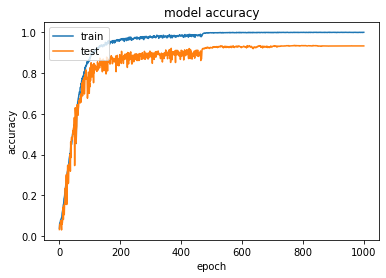

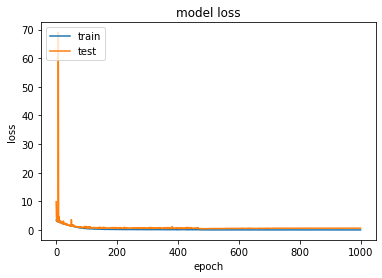

In [44]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()